In [2]:
import polars as pl

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [146]:
df = pl.read_parquet("PEPEUSDT_kline.parquet")

In [147]:
df2 = pl.read_parquet("PEPEUSDT_metrics.parquet")

In [148]:
df2 =  df2.with_columns([pl.col("create_time").dt.timestamp("ms")])

In [149]:
df3 = df.join(df2,left_on="open_time",right_on="create_time")


In [150]:
shift_columns=[
    'sum_open_interest',
    'sum_open_interest_value',
    'count_toptrader_long_short_ratio',
    'sum_toptrader_long_short_ratio',
    'count_long_short_ratio',
    'sum_taker_long_short_vol_ratio']

In [151]:
df3 = df3.with_columns([pl.col(item).shift(1) for item in shift_columns])

In [152]:
df3 = df3.drop_nulls()

In [153]:
from finml.utils.stats import corrections

In [154]:

import polars as pl 
import numpy as np 


def calc_change_since_pivot(current,last_pivot):
    if(last_pivot == 0): last_pivot = 1 ** (-100) # avoid division by 0
    perc_change_since_pivot = (current - last_pivot) / abs(last_pivot)
    return perc_change_since_pivot

def get_zigzag(idx, row, taip=None):
    '''
    item:datetime,close,high,low
    '''
    if (taip == "Peak"):
        key = 2
    elif (taip == "Trough"):
        key = 3
    else:
        key = 1

    return {
        "datetime": row[0],
        "value": row[key],
        "type": taip,
        "idx":idx,
    }

def create_label(
    df,
    threshold = 0.02,
    stop_loss = None,
    cut_label = True,
    log_return = True,
):
    zigzags = []
    for idx,item in enumerate(df.select(["datetime","close","high","low"]).iter_rows()):
        is_starting = (idx == 0)
        if is_starting:
            zigzags.append(get_zigzag(idx,item))
            continue  

        is_first_line = (len(zigzags) == 1) 
        if is_first_line:
            perc_change_since_pivot = calc_change_since_pivot(item[1],zigzags[-1]["value"])
            if abs(perc_change_since_pivot) >= threshold:
                if perc_change_since_pivot > 0:
                    zigzags.append(get_zigzag(idx, item,"Peak"))
                    zigzags[0]["type"] = "Through"
                else:
                    zigzags.append(get_zigzag(idx, item, "Trough"))
                    zigzags[0]["type"] = "Peak" 
            continue 
        is_through = zigzags[-2]["value"] > zigzags[-1]["value"]
        is_ending = (idx == df.shape[0] - 1)
        last_pivot = float(zigzags[-1]["value"])
        # based on last pivot type, look for reversal or continuation
        if(is_through):
            perc_change_since_pivot = calc_change_since_pivot(item[1],zigzags[-1]["value"])
            is_reversing = (perc_change_since_pivot >= threshold) or is_ending
            is_continuing = item[1] <= last_pivot
            if (is_continuing): 
                zigzags[-1] = get_zigzag(idx,item, "Trough")
            elif (is_reversing): 
                zigzags.append(get_zigzag(idx,item, "Peak"))
        else:
            perc_change_since_pivot = calc_change_since_pivot(item[1],zigzags[-1]["value"])
            is_reversing = (perc_change_since_pivot <= -threshold) or is_ending
            is_continuing = item[1] >= last_pivot
            if(is_continuing): 
                zigzags[-1] = get_zigzag(idx,item, "Peak")
            elif (is_reversing): 
                zigzags.append(get_zigzag(idx,item, "Trough"))

    zigzags = pl.DataFrame(zigzags)
    zigzags = zigzags.select([
        pl.all(),
        pl.col("datetime").shift(-1).alias("event_ends"),
        pl.col("value").shift(-1).alias("prevext")
    ])
    assert zigzags.shape[0] >=2 
    df = df.join(zigzags, on = "datetime", how = "left")
    df = df.select(
        [pl.col(item).fill_null(strategy = "forward") if item in ["prevext","event_ends"] else pl.col(item) for item in df.columns]
    )
    df = df.select(
        [pl.all(), (pl.col("prevext")/pl.col("close") - 1.0).alias("label")]
    )
    correct_label = [] 
    event_ends = [] 
    if stop_loss:
        total_returns = df.select("label").to_numpy().flatten() 
        original_event_ends = df.select("event_ends").to_numpy().flatten() 
        original_datetime = df.select("datetime").to_numpy().flatten() 
        close_array = df.select("close").to_numpy().flatten() 
        high_array = df.select("high").to_numpy().flatten()
        low_array = df.select("low").to_numpy().flatten()

        for i in range(zigzags.shape[0]-1):
            start_idx = zigzags[i,"idx"]
            end_idx = zigzags[i+1,"idx"]
            next_end_idx = zigzags[i+2,"idx"] if i+2 < zigzags.shape[0] else df.shape[0]-1
            for j in range(start_idx,end_idx):
                if total_returns[j] > 0:
                    min_acc_arg = np.argmin(low_array[j+1:end_idx+1]) + j+1
                    min_acc = min((low_array[min_acc_arg]-close_array[j])/close_array[j],0)
                    if min_acc > -stop_loss:
                        correct_label.append(total_returns[j])
                        event_ends.append(original_event_ends[j])
                    else:
                        correct_label.append(min_acc)
                        event_ends.append(original_datetime[min_acc_arg])
                else:
                    min_acc_arg = np.argmax(high_array[j+1:end_idx+1]) + j+1
                    min_acc = max((high_array[min_acc_arg]-close_array[j])/close_array[j],0)
                    if min_acc < stop_loss:
                        correct_label.append(total_returns[j])
                        event_ends.append(original_event_ends[j])
                    else:
                        correct_label.append(min_acc)
                        event_ends.append(original_datetime[min_acc_arg])
        #replace label of df 
        df = df[:len(correct_label),:]
        df.replace("label",pl.Series(correct_label))
        df.replace("event_ends",pl.Series(event_ends))
       
    ## drop the front data because zigzag is meanless on these data 
    df = df.filter((pl.col("datetime")>=zigzags[1,"datetime"]))

    df = df.select(pl.all().exclude(['value', 'type', 'idx', 'prevext']))
    df = df.with_columns( [pl.col("datetime").alias("event_starts")])
    if cut_label:
        label_array = df[:,"label"].to_numpy()
        df = df.select([
            pl.all().exclude("label"),
            (pl.when(pl.col("label")>label_array.mean() +5.0*label_array.std())
             .then(label_array.mean() +5.0*label_array.std())
             .otherwise(pl.col("label"))).alias("label"),
        ])
        df = df.select([
            pl.all().exclude("label"),
            (pl.when(pl.col("label")< label_array.mean() - 5.0*label_array.std())
             .then(label_array.mean() - 5.0*label_array.std())
             .otherwise(pl.col("label"))).alias("label"),
        ])
    df = df.select(
            [pl.all(), pl.arange(0, pl.count()).alias("count_index")]
        )
    if log_return:
        df = df.with_columns(
            [
                (pl.col("label")+1.0).log().alias("label"),
            ]
        )

    return df 

In [155]:
df3 = df3.with_columns(pl.col("open_time").alias("datetime"))

In [156]:

labeled_df = create_label(df3,    threshold = 0.03,
    stop_loss = 0.008,
    cut_label = False,
    log_return = True)

In [157]:
labeled_df

open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,symbol,sum_open_interest,sum_open_interest_value,count_toptrader_long_short_ratio,sum_toptrader_long_short_ratio,count_long_short_ratio,sum_taker_long_short_vol_ratio,datetime,event_ends,label,event_starts,count_index
i64,f64,f64,f64,f64,i64,i64,f64,i64,i64,f64,i64,str,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64
1683593400000,0.0018831,0.0018856,0.0017832,0.0017832,4441109298,1683593699999,8.1503e6,23317,1260328549,2.3189e6,0,"""1000PEPEUSDT""",2.3348e10,4.4202e7,1.761619,0.977537,1.642254,1.38637,1683593400000,1683593700000,-0.008165,1683593400000,0
1683593700000,0.0017832,0.0018217,0.0017687,0.0018139,7491775480,1683593999999,1.3490e7,37096,3714200570,6.6914e6,0,"""1000PEPEUSDT""",2.3314e10,4.3997e7,1.781899,0.975177,1.654445,1.004685,1683593700000,1683594000000,-0.015389,1683593700000,1
1683594000000,0.0018136,0.0018242,0.0017862,0.001809,4608083876,1683594299999,8.3400e6,25939,2202475686,3.9884e6,0,"""1000PEPEUSDT""",2.3174e10,4.1724e7,1.768608,0.987239,1.552028,0.396595,1683594000000,1683597300000,0.065833,1683594000000,2
1683594300000,0.001809,0.0018511,0.0018025,0.0018298,4249467729,1683594599999,7.7946e6,23967,2260956860,4.1505e6,0,"""1000PEPEUSDT""",2.2444e10,4.0653e7,1.753202,0.980049,1.524463,0.983224,1683594300000,1683595500000,-0.011543,1683594300000,3
1683594600000,0.0018298,0.0018516,0.0018166,0.001825,1968366161,1683594899999,3.6167e6,12429,984042582,1.8093e6,0,"""1000PEPEUSDT""",2.2710e10,4.1105e7,1.751251,0.98163,1.508441,0.915478,1683594600000,1683595500000,-0.008916,1683594600000,4
1683594900000,0.0018251,0.0018442,0.0018251,0.0018345,1134180494,1683595199999,2.0819e6,7896,500486516,918615.486701,0,"""1000PEPEUSDT""",2.2715e10,4.1556e7,1.789072,0.975458,1.55757,1.1365795,1683594900000,1683595500000,-0.014108,1683594900000,5
1683595200000,0.0018345,0.0018455,0.0018137,0.0018274,1387087908,1683595499999,2.5377e6,11060,613075694,1.1222e6,0,"""1000PEPEUSDT""",2.2749e10,4.1480e7,1.796074,0.978016,1.558111,1.003113,1683595200000,1683595500000,-0.010231,1683595200000,6
1683595500000,0.0018274,0.0018463,0.0018088,0.0018454,1973784450,1683595799999,3.6074e6,14479,1053240500,1.9262e6,0,"""1000PEPEUSDT""",2.2932e10,4.2010e7,1.777321,0.980643,1.5464,0.789792,1683595500000,1683597300000,0.045911,1683595500000,7
1683595800000,0.0018453,0.001893,0.0018335,0.0018733,4011648970,1683596099999,7.4960e6,24940,2360866352,4.4127e6,0,"""1000PEPEUSDT""",2.3021e10,4.2066e7,1.770089,0.979842,1.530136,0.792075,1683595800000,1683596400000,-0.013327,1683595800000,8


In [158]:
df3.columns

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_volume',
 'count',
 'taker_buy_volume',
 'taker_buy_quote_volume',
 'ignore',
 'symbol',
 'sum_open_interest',
 'sum_open_interest_value',
 'count_toptrader_long_short_ratio',
 'sum_toptrader_long_short_ratio',
 'count_long_short_ratio',
 'sum_taker_long_short_vol_ratio',
 'datetime']

In [200]:
for col in shift_columns:
        factor = labeled_df.select([pl.col("datetime"),(pl.col(col)-pl.col(col).rolling_mean(20))/pl.col(col).rolling_std(20)])
        label = labeled_df.select([pl.col('datetime'),pl.col("label")])
        corr = corrections(
            factor,
            label,
            corr_type ="pearson",
        )
        print(corr)

Empty DataFrame
Columns: [IS_label_corr, OS_label_corr]
Index: []
Empty DataFrame
Columns: [IS_label_corr, OS_label_corr]
Index: []
Empty DataFrame
Columns: [IS_label_corr, OS_label_corr]
Index: []
Empty DataFrame
Columns: [IS_label_corr, OS_label_corr]
Index: []
                        IS_label_corr  OS_label_corr
count_long_short_ratio      -0.005392      -0.030799
Empty DataFrame
Columns: [IS_label_corr, OS_label_corr]
Index: []


In [ ]:
#count_toptrader_long_short_ratio  0.06 左右
#sum_toptrader_long_short_ratio  std 0.04+0.09
#count_toptrader_long_short_ratio

In [160]:
labeled_df.lazy().select(pl.rolling_corr("close","high",window_size==5))

AttributeError: module 'polars' has no attribute 'rolling_corr'

In [161]:
!pip install poalrs

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement poalrs (from versions: none)
ERROR: No matching distribution found for poalrs


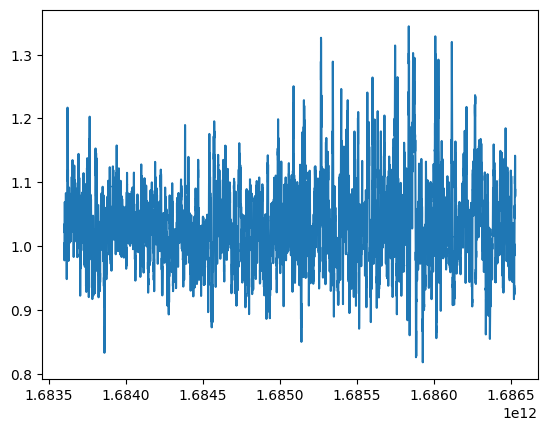

In [162]:
plt.plot(labeled_df["datetime"],labeled_df['sum_taker_long_short_vol_ratio'].rolling_mean(20))

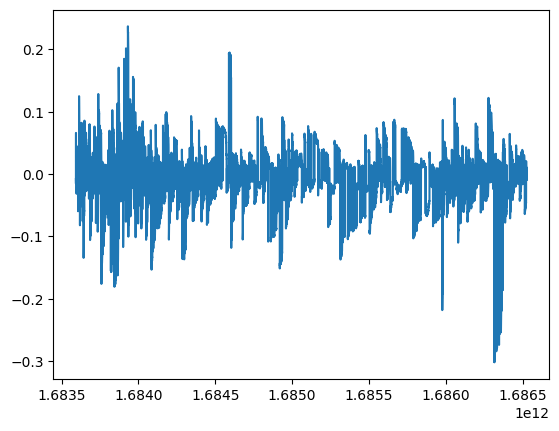

In [163]:
plt.plot(labeled_df["datetime"],labeled_df['label'])

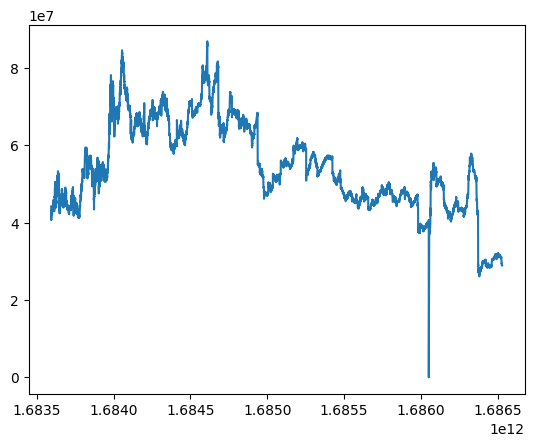

In [164]:
plt.plot(labeled_df["datetime"],labeled_df['sum_open_interest_value'])

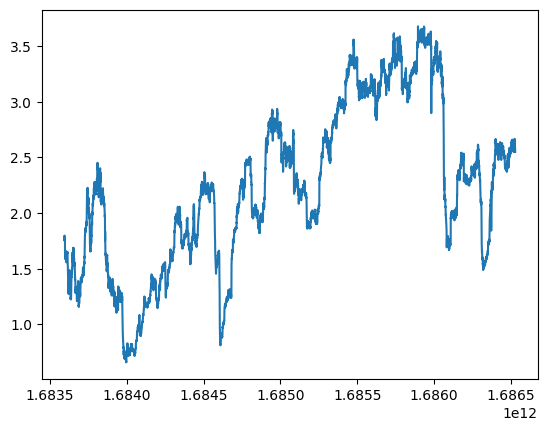

In [165]:
plt.plot(labeled_df["datetime"],labeled_df["count_toptrader_long_short_ratio"])

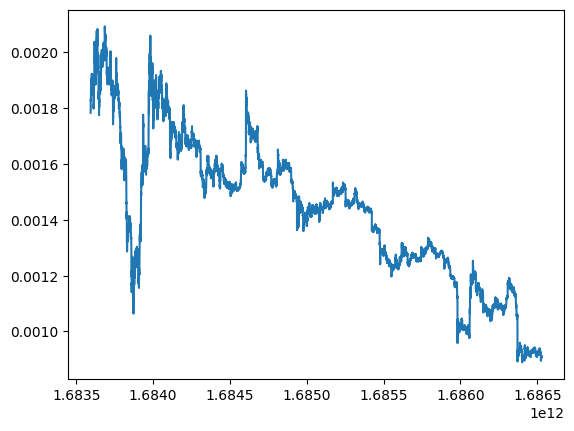

In [166]:
plt.plot(labeled_df["datetime"],labeled_df["close"])

In [215]:
filter_df = labeled_df.filter((pl.col('sum_taker_long_short_vol_ratio')>1)& ( pl.col('sum_taker_long_short_vol_ratio').shift()<1))

In [216]:
len(filter_df)

2446

In [218]:
for col in shift_columns:
        factor = filter_df.select([pl.col("datetime"),pl.col(col).diff(1)])
        label = filter_df.select([pl.col('datetime'),pl.col("label")])
        corr = corrections(
            factor,
            label,
            corr_type ="pearson",
        )
        print(corr)

Empty DataFrame
Columns: [IS_label_corr, OS_label_corr]
Index: []
                         IS_label_corr  OS_label_corr
sum_open_interest_value       -0.02392      -0.004809
                                  IS_label_corr  OS_label_corr
count_toptrader_long_short_ratio      -0.041082      -0.015859
Empty DataFrame
Columns: [IS_label_corr, OS_label_corr]
Index: []
                        IS_label_corr  OS_label_corr
count_long_short_ratio      -0.033198      -0.053742
Empty DataFrame
Columns: [IS_label_corr, OS_label_corr]
Index: []
